In [4]:
import pandas as pd #for data processing
import numpy as np #for algebra and calculations
import matplotlib.pyplot as plt #for plotting data
import seaborn as sns

<AxesSubplot:>

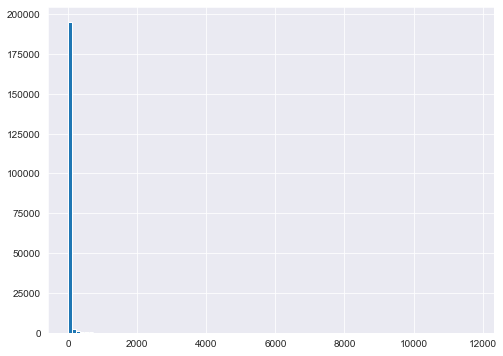

In [99]:
# Load and cleanse 
"""Please download the data at https://www.kaggle.com/datasets/tamber/steam-video-games and add to your directory before use."""
metadata = pd.read_csv('steam-200k.csv', low_memory=False,header = None,memory_map = True,encoding =  'utf-8')
metadata.columns = ['User_ID','Game_Name','Action','Playtime','0']

#general look at the playtime of users
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
metadata['Playtime'].hist(bins=100)

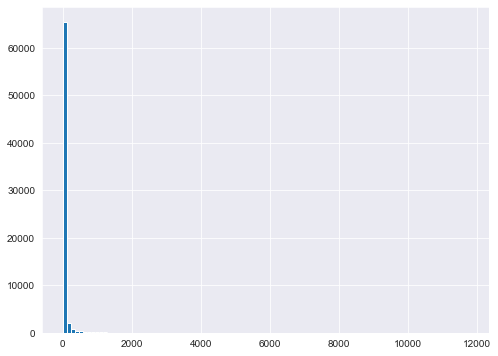

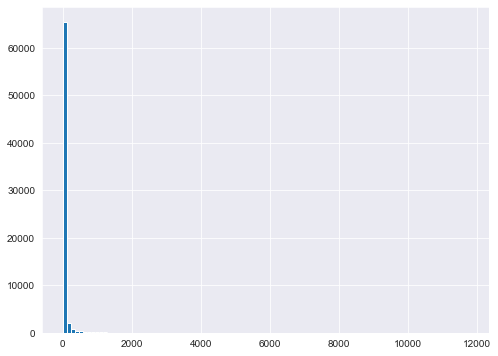

In [127]:
## Filtering out any purchase data.
metadata = metadata[metadata.Action == 'play']
## Resetting index numbers
metadata.reset_index(inplace=True,drop=True)

plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
metadata['Playtime'].hist(bins=100)

plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
metadata['Playtime'].hist(bins=100)

## Adding new metrics of count of plays and how many hours average has a user played
metrics = {'Action':'Count Plays','Playtime':'Avg Hours Played'}
metrics_meta = metadata.groupby(['Game_Name'], as_index=False).agg({'Action':'count','Playtime':'mean'}).rename(columns=metrics)
## Remove the lower 25% of play count so that only games with 12 players or more are recommended.
metrics_meta = metrics_meta.loc[metrics_meta['Count Plays'] >= metrics_meta['Count Plays'].quantile(0.75)]

metrics_meta.sort_values(['Avg Hours Played'],ascending = False)
## Create a popularity score based on plays and the amount of hours played on average.
scorer = round((metrics_meta['Count Plays']*metrics_meta['Avg Hours Played'])/100,)
scorer.sort_values(ascending = False)
metrics_meta['Score'] = scorer
metrics_meta['Score'] = metrics_meta['Score'].astype(int)
##Creating an ID for each game for possible deep learning use
metrics_meta['Game_ID'] = pd.factorize(metrics_meta['Game_Name'])[0]+1
## merge all dataframes together on the game name, removing unwanted games.
recommendations = pd.merge(metadata,metrics_meta,on = 'Game_Name',how = 'inner')

         User_ID                     Game_Name Action  Playtime  0  \
7514        5250                        Dota 2   play       0.2  0   
28638       5250                   Alien Swarm   play       4.9  0   
17028       5250      Deus Ex Human Revolution   play      62.0  0   
16681       5250                      Portal 2   play      13.6  0   
3160        5250               Team Fortress 2   play       0.8  0   
...          ...                           ...    ...       ... ..   
7204   309434439                        Dota 2   play       0.8  0   
52464  309554670             Mitos.is The Game   play       5.9  0   
18733  309626088  Age of Empires II HD Edition   play       6.7  0   
6181   309824202                        Dota 2   play       0.7  0   
9047   309903146                        Dota 2   play       0.2  0   

       Count Plays  Avg Hours Played  Score  Game_ID  
7514          4841        202.785499   9817      244  
28638          289          5.207612     15      

<Figure size 576x432 with 0 Axes>

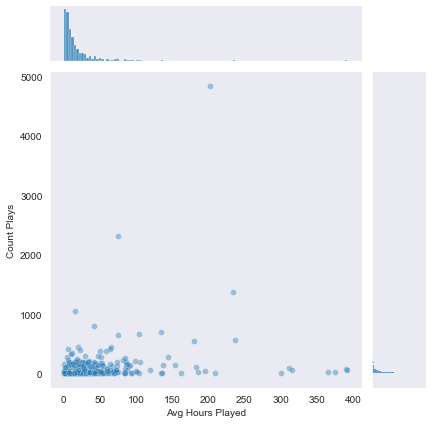

In [126]:
print(recommendations.sort_values(['User_ID'],ascending = True))
print()
# Average hours played  scatter plot


plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='Avg Hours Played', y='Count Plays', data=metrics_meta, alpha=0.4)

<AxesSubplot:>

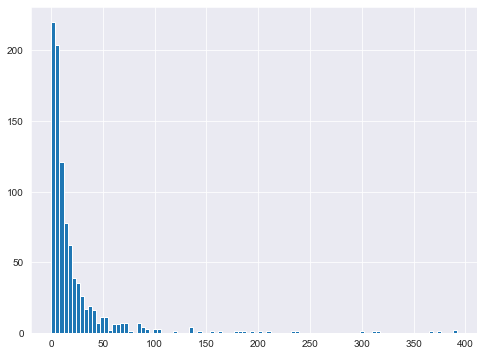

In [87]:
## Average hours played histogram
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
metrics_meta['Avg Hours Played'].hist(bins=100)

                                                   Correlation  \
Game_Name                                                        
Fallout 4                                             1.000000   
Fallout New Vegas                                     0.348329   
The Elder Scrolls V Skyrim                            0.284048   
The Witcher 3 Wild Hunt                               0.283960   
Grand Theft Auto V                                    0.259738   
The Witcher 2 Assassins of Kings Enhanced Edition     0.255842   

                                                   Avg Hours Played  
Game_Name                                                            
Fallout 4                                                 64.447904  
Fallout New Vegas                                         51.682578  
The Elder Scrolls V Skyrim                               104.710931  
The Witcher 3 Wild Hunt                                   63.336364  
Grand Theft Auto V                                 

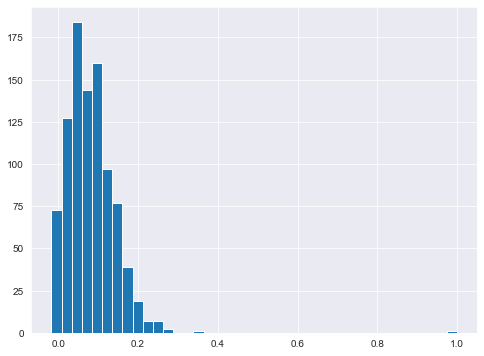

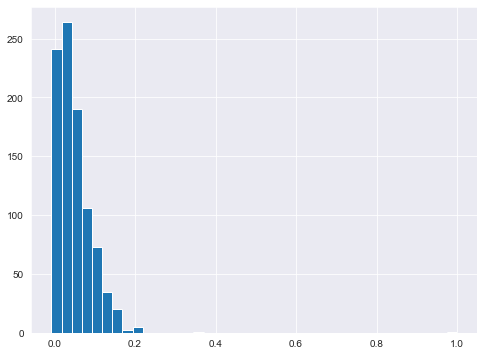

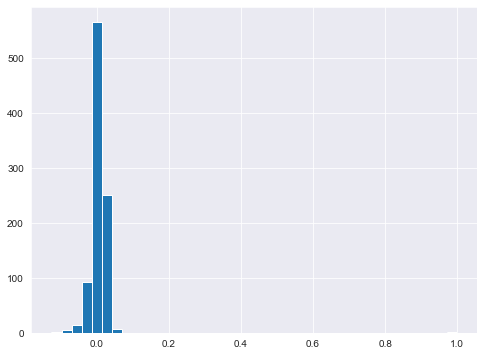

In [130]:
## Collaborative based filter
def recommendation(title):
    recommendations.groupby('Game_Name')['Score'].count().sort_values(ascending=False).head()
    ratings_mean_count = pd.DataFrame(recommendations.groupby('Game_Name')['Avg Hours Played'].mean())
    ratings_mean_count['Count_of_Players'] = pd.DataFrame(recommendations.groupby('Game_Name')['Avg Hours Played'].count())


    game_score = recommendations.pivot_table(index='User_ID', columns='Game_Name', values='Avg Hours Played').notnull()
    recommend_score = game_score[title]
    recommend_score.head()
    #print(recommend_score) ## Shows True/False if User has played game
    similar_games = game_score.corrwith(recommend_score)

    corr_recommend = pd.DataFrame(similar_games, columns=['Correlation'])
    
    corr_recommend.dropna(inplace=True)
    corr_recommend = corr_recommend.join(ratings_mean_count['Avg Hours Played'])
    print(corr_recommend[corr_recommend ['Avg Hours Played']>3].sort_values('Correlation', ascending=False).head(6))
    ## Average hours played histogram
    plt.figure(figsize=(8,6))
    plt.rcParams['patch.force_edgecolor'] = True
    corr_recommend ['Correlation'].hist(bins=40)
recommendation('Fallout 4')
recommendation('The Binding of Isaac Rebirth')
recommendation('Dota 2')

